In [98]:
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore",category=np.VisibleDeprecationWarning)

dataset = np.loadtxt("/Users/Keshavamurthy/allfeatures1.txt", delimiter=" ");
print(dataset.shape)

np.random.shuffle(dataset)

X = dataset[:, :34]
Y = dataset[:, 34]
botnetDataset = dataset[dataset[:,34]==1, :]
normalDataset = dataset[dataset[:,34]==0, :]

botnetX = botnetDataset[:,:34]
botnetY = botnetDataset[:, 34]

normalX = normalDataset[:,:34]
normalY = normalDataset[:, 34]

scaler = MinMaxScaler(feature_range=(0, 1))
rescaledBotnetX = scaler.fit_transform(botnetX)
rescaledNormalX = scaler.fit_transform(normalX)
rescaledX = scaler.fit_transform(X)

valid_start_index = 0
valid_end_index = 1000
test_start_index = 1000
test_end_index = 2000
num_labels = 2

validation_dataset = np.concatenate((rescaledBotnetX[valid_start_index:valid_end_index,:], 
                                     rescaledNormalX[valid_start_index:valid_end_index,:]))
valid_labels = np.concatenate((botnetY[valid_start_index:valid_end_index], 
                                   normalY[valid_start_index:valid_end_index]))
valid_labels = (np.arange(num_labels) == valid_labels[:,None]).astype(np.float64)

test_dataset = np.concatenate((rescaledBotnetX[test_start_index:test_end_index,:], 
                               rescaledNormalX[test_start_index:test_end_index,:]))
test_labels = np.concatenate((botnetY[test_start_index:test_end_index], 
                             normalY[test_start_index:test_end_index]))
test_labels = (np.arange(num_labels) == test_labels[:,None]).astype(np.float64)

train_dataset = np.concatenate((rescaledBotnetX[test_end_index:,:], 
                               rescaledNormalX[test_end_index:,:]))
train_labels = np.concatenate((botnetY[test_end_index:], 
                             normalY[test_end_index:]))
train_labels = (np.arange(num_labels) == train_labels[:,None]).astype(np.float64)

print(validation_dataset.shape, valid_labels.shape)
print(test_dataset.shape, test_labels.shape)
print(train_dataset.shape, train_labels.shape)

(52580, 35)
(2000, 34) (2000, 2)
(2000, 34) (2000, 2)
(48580, 34) (48580, 2)


In [110]:
import tensorflow as tf

num_features = 34
batch_size = 1024
num_hidden_nodes = 4096

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float64, shape=(batch_size, num_features))
    tf_train_labels = tf.placeholder(tf.float64, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(validation_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float64)
    
    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([num_features, num_hidden_nodes], dtype=tf.float64), dtype=tf.float64)
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes], dtype=tf.float64), dtype=tf.float64)
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels], dtype=tf.float64), dtype=tf.float64)
    biases2 = tf.Variable(tf.zeros([num_labels], dtype=tf.float64), dtype=tf.float64)
    
    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(lay1_train, 0.5)
    logits = tf.matmul(drop1, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)
  


In [111]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

In [112]:
def GetNextBotnetSet(rescaledX, Y):
    step = 4000
    prevStep = 0
    while step < rescaledX.shape[0]:
        yield rescaledX[prevStep:step, :], Y[prevStep:step]
        prevStep = step
        step = step + 4000
        
    return rescaledX[prevStep:, :], Y[prevStep:]

In [113]:
num_steps = 60
offset = int(test_end_index)
trainNormalX = rescaledNormalX[test_end_index:, :]
class_batch_size = int(batch_size)/2

with tf.Session(graph=graph) as session:
    
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        np.random.shuffle(trainNormalX)
        train_batch_data = np.concatenate((rescaledBotnetX[offset:(offset+class_batch_size),:], 
                               trainNormalX[:class_batch_size,:]))
        train_batch_labels = np.concatenate((botnetY[:class_batch_size], 
                             normalY[:class_batch_size]))
        train_batch_labels = (np.arange(num_labels) == train_batch_labels[:,None]).astype(np.float64)
        offset = offset + class_batch_size
        
        feed_dict = {tf_train_dataset : train_batch_data, 
                     tf_train_labels : train_batch_labels, 
                     beta_regul : 3e-4
                    }
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, train_batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 21.819545
Minibatch accuracy: 52.1%
Validation accuracy: 82.4%
Minibatch loss at step 50: 17.531123
Minibatch accuracy: 88.1%
Validation accuracy: 90.2%
Test accuracy: 90.7%


In [103]:
regul_val = [pow(10, i) for i in np.arange( -4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
    offset = int(test_end_index)
    trainNormalX = rescaledNormalX[test_end_index:, :]
    class_batch_size = int(batch_size)/2
    
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            np.random.shuffle(trainNormalX)
            train_batch_data = np.concatenate((rescaledBotnetX[offset:(offset+class_batch_size),:], 
                                   trainNormalX[:class_batch_size,:]))
            train_batch_labels = np.concatenate((botnetY[:class_batch_size], 
                                 normalY[:class_batch_size]))
            train_batch_labels = (np.arange(num_labels) == train_batch_labels[:,None]).astype(np.float64)
            offset = offset + class_batch_size
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : train_batch_data, 
                         tf_train_labels : train_batch_labels,
                         beta_regul : regul
                        }
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        print("Accuracy for regularization param %.3f: %.1f", (regul, accuracy(test_prediction.eval(), test_labels)))
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
        
print(accuracy_val)    

Accuracy for regularization param %.3f: %.1f (0.0001, 92.049999999999997)
Accuracy for regularization param %.3f: %.1f (0.00012589254117941674, 90.700000000000003)
Accuracy for regularization param %.3f: %.1f (0.00015848931924611142, 91.650000000000006)
Accuracy for regularization param %.3f: %.1f (0.00019952623149688809, 91.599999999999994)
Accuracy for regularization param %.3f: %.1f (0.00025118864315095823, 91.799999999999997)
Accuracy for regularization param %.3f: %.1f (0.00031622776601683826, 93.25)
Accuracy for regularization param %.3f: %.1f (0.00039810717055349773, 91.799999999999997)
Accuracy for regularization param %.3f: %.1f (0.00050118723362727296, 91.950000000000003)
Accuracy for regularization param %.3f: %.1f (0.00063095734448019429, 91.75)
Accuracy for regularization param %.3f: %.1f (0.00079432823472428294, 90.549999999999997)
Accuracy for regularization param %.3f: %.1f (0.001000000000000002, 91.349999999999994)
Accuracy for regularization param %.3f: %.1f (0.001258

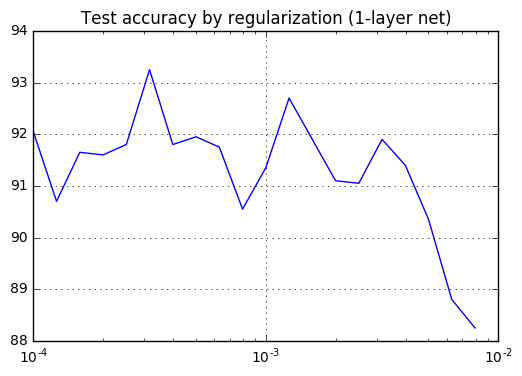

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer net)')
plt.show()